# Estudio de Ascenso de Gradientes con una distribución binomial

En este estudio vamos a utilizar una distribución binomial.

In [ ]:
!git clone https://github.com/josesanchfez-umu/k_brazos_SFDD.git
# Instalar dependencias
!pip install -r ./k_brazos_SFDD/requirementsColab.txt

In [ ]:
import sys

# Añadir los directorios fuentes al path de Python
sys.path.append('./src')


# Verificar que se han añadido correctamente
print(sys.path)

import numpy as np
from typing import List

from algorithms import Algorithm, Softmax, GradientBandit
from arms.armbinomial import ArmBinomial
from arms import Bandit
from plotting import plot_average_rewards, plot_optimal_selections, plot_arm_statistics, plot_regret

['C:\\Users\\jasf7\\AppData\\Local\\Programs\\Python\\Python312\\python312.zip', 'C:\\Users\\jasf7\\AppData\\Local\\Programs\\Python\\Python312\\DLLs', 'C:\\Users\\jasf7\\AppData\\Local\\Programs\\Python\\Python312\\Lib', 'C:\\Users\\jasf7\\AppData\\Local\\Programs\\Python\\Python312', 'd:\\Escritorio\\Universidad\\master\\Asignaturas\\EML\\Practica1\\k_brazos_SFDD\\veml', '', 'd:\\Escritorio\\Universidad\\master\\Asignaturas\\EML\\Practica1\\k_brazos_SFDD\\veml\\Lib\\site-packages', 'd:\\Escritorio\\Universidad\\master\\Asignaturas\\EML\\Practica1\\k_brazos_SFDD\\veml\\Lib\\site-packages\\win32', 'd:\\Escritorio\\Universidad\\master\\Asignaturas\\EML\\Practica1\\k_brazos_SFDD\\veml\\Lib\\site-packages\\win32\\lib', 'd:\\Escritorio\\Universidad\\master\\Asignaturas\\EML\\Practica1\\k_brazos_SFDD\\veml\\Lib\\site-packages\\Pythonwin', './src/']


In [2]:
seed = 42
def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):

    optimal_arm = bandit.optimal_arm  # Necesario para calcular el porcentaje de selecciones óptimas.

    optimal_reward = bandit.get_expected_value(optimal_arm) # Recompensa esperada del brazo óptimo.

    rewards = np.zeros((len(algorithms), steps)) # Matriz para almacenar las recompensas promedio.

    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.

    regret_accumulated = np.zeros((len(algorithms), steps))  # Matriz del rechazo acumulado

    arm_stats = [(algo, {arm: [0, 0] for arm in range(len(bandit.arms))}) for algo in algorithms] # TODO: Lista para almacenar estadísticas por cada algoritmo

    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)

        for algo in algorithms:
            algo.reset() # Reiniciar los valores de los algoritmos.

        total_rewards_per_algo = np.zeros(len(algorithms)) # Acumulador de recompensas por algoritmo. Necesario para calcular el promedio.

        cumulative_regret = np.zeros(len(algorithms))   # Acumulador de rechazo acumulado por algoritmo.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm() # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm) # Obtener la recompensa del brazo seleccionado.
                algo.update(chosen_arm, reward) # Actualizar el valor estimado del brazo seleccionado.

                rewards[idx, step] += reward # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                total_rewards_per_algo[idx] += reward # Acumular la recompensa obtenida en total_rewards_per_algo para el algoritmo idx.

                # TODO: (arm_statistics) Buscar el conjunto de estadísticas correspondiente a este algoritmo
                _, stats = arm_stats[idx]
                # Registrar selecciones y recompensas en arm_stats
                stats[chosen_arm][0] += 1  # Contador de selecciones
                stats[chosen_arm][1] += reward  # Suma de recompensas

                #TODO: (optimal_selections) modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm
                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

                # Cálculo del rechazo
                regret = optimal_reward - reward  
                cumulative_regret[idx] += regret  # Acumular regret total
                regret_accumulated[idx, step] += cumulative_regret[idx] 


    rewards /= runs

    # TODO: (optimal_selections) calcular el porcentaje de selecciones óptimas y almacenar en optimal_selections
    optimal_selections = (optimal_selections / runs) * 100  # Convertir a porcentaje

    regret_accumulated /= runs  # Calcular el rechazo acumulado promedio

    # TODO: (arm_statistics) Calcular la recompensa promedio para cada brazo
    for _, stats in arm_stats:
        for arm in stats:
            selections, total_reward = stats[arm]
            stats[arm] = (selections, total_reward / selections if selections > 0 else 0)

    return rewards, optimal_selections, arm_stats, regret_accumulated

## Softmax

Para este algoritmo, vamos a utilizar su parámetro τ, que controla el equilibrio entre exploración y explotación.
- Si τ es grande, todos los brazos tienen probabilidades similares para ser elegidos, lo que promueve la exploración.
- Si τ es pequeña, el brazo con mayor recompensa estimada se elige con mayor probabilidad, lo que prioriza la explotación.
- Si τ es 0, el algoritmo se comporta como un greedy puro, escogiendo siempre el mejor brazo estimado (pura explotación).

In [3]:

# Parámetros del experimento
seed = 42
# Fijar la semilla para reproducibilidad
np.random.seed(seed)  

# Número de brazos
k = 10 
# Número de pasos que se ejecutarán cada algoritmo
steps = 1000
# Número de ejecuciones  
runs = 500  

# Generar un bandido con k brazos de distribución Bernoulli
bandit = Bandit(arms=ArmBinomial.generate_arms(k)) 
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
softmax_algorithms = [Softmax(k=k, temperature=0.1), Softmax(k=k, temperature=0.5), Softmax(k=k, temperature=2)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
softmax_rewards, softmax_optimal_selections, softmax_arm_stats, softmax_regret_accumulated = run_experiment(bandit, softmax_algorithms, steps, runs)

Bandit with 10 arms: ArmBinomial(n=11, p=0.22479561626896213), ArmBinomial(n=8, p=0.14646688973455957), ArmBinomial(n=17, p=0.7929409166199481), ArmBinomial(n=19, p=0.5808920093945671), ArmBinomial(n=15, p=0.6664580622368363), ArmBinomial(n=12, p=0.11646759543664197), ArmBinomial(n=17, p=0.8759278817295955), ArmBinomial(n=9, p=0.7659541126403374), ArmBinomial(n=11, p=0.26987128854262094), ArmBinomial(n=14, p=0.24545997376568052)
Optimal arm: 7 with expected reward=14.890773989403122


### Recompensa promedio

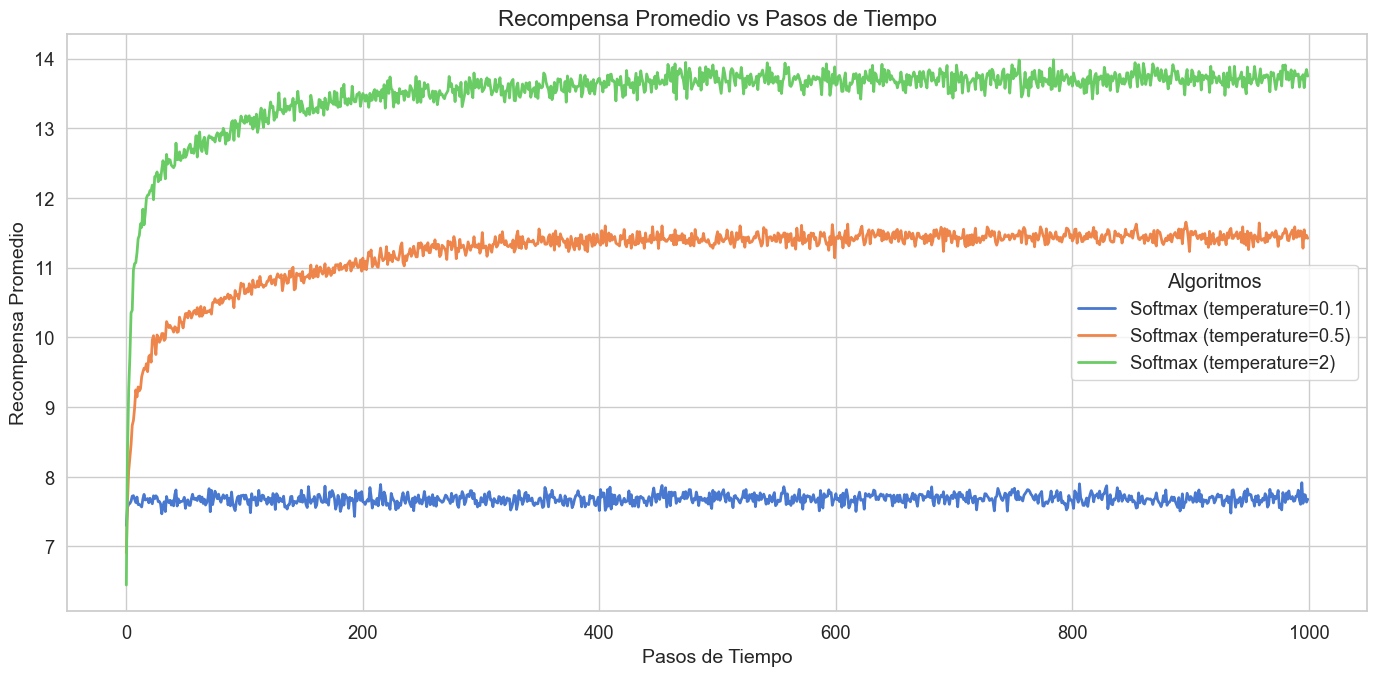

In [4]:
plot_average_rewards(steps, softmax_rewards, softmax_algorithms)

- **Softmax (temperature=0.1):** con este valor, el algoritmo escoge las acciones con la mayor probabilidad estimada de recompensa, pero explora muy poco. Como resultado, podría quedarse atrapado en soluciones subóptimas (es decir, acciones que parecen buenas inicialmente pero no lo son en el largo plazo), lo que lleva a recompensas promedio más bajas.
- **Softmax (temperature=0.5):** aquí, el algoritmo logra un balance mejor entre exploración y explotación, permitiendo descubrir mejores opciones de acción con el tiempo. Esto resulta en un desempeño superior al de la configuración con temperatura más baja.
- **Softmax (temperature=2):** este valor promueve más exploración, lo que en este caso permite al algoritmo encontrar consistentemente las mejores opciones de acción. Por ello, alcanza recompensas más altas y estables. Sin embargo, si la temperatura fuera aún mayor, podría volverse demasiado exploratorio, lo que degradaría el rendimiento.

El valor de temperatura controla cómo el Softmax balancea exploración y explotación. En este caso y con esta distribución, vemos que un enfoque más exploratorio (temperatura más alta) resulta más exitoso a la hora de encontrar acciones con mayores recompensas promedio.

### Rechazo acumulado

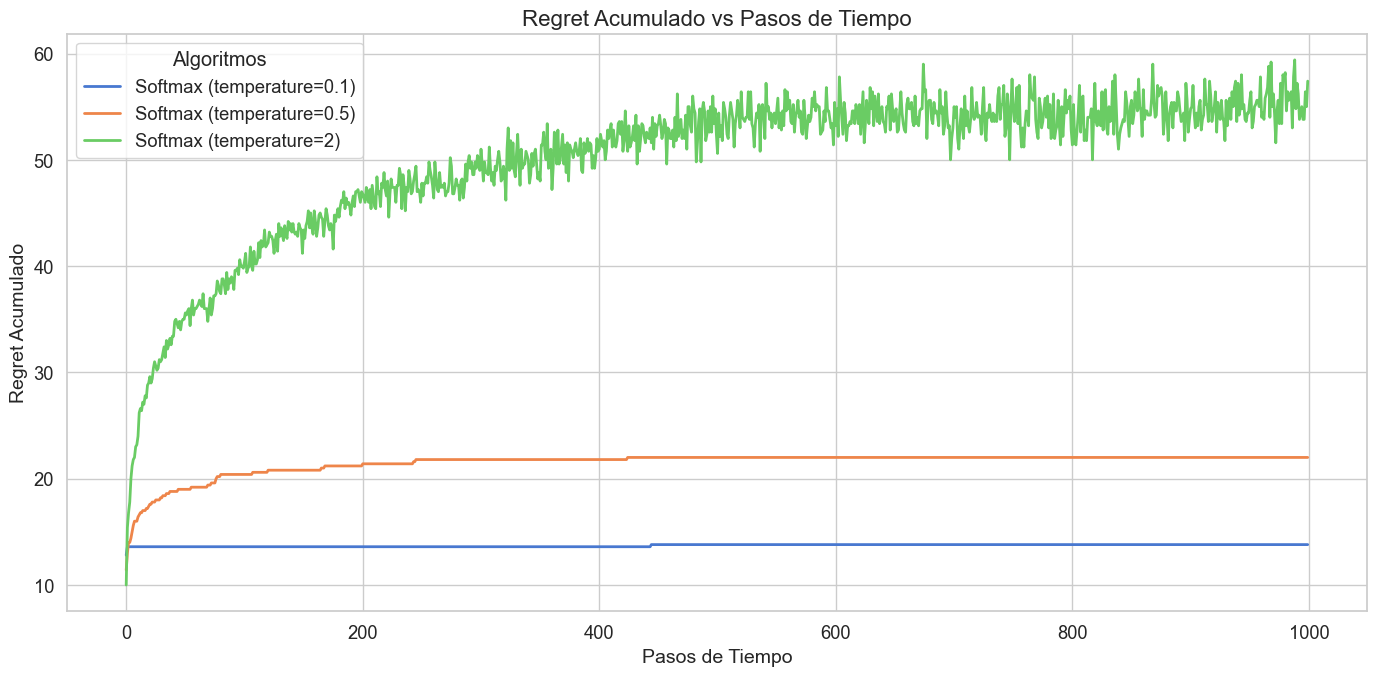

In [5]:
plot_regret(steps, softmax_optimal_selections, softmax_algorithms)

En esta gráfica se muestra el rechazo acumulado obtenido por parte de los tres algoritmos:

- **Softmax (temperature=0.1):** tiene el menor regret acumulado y se mantiene bastante estable. La baja temperatura fuerza al algoritmo a explotar principalmente las opciones más prometedoras que conoce. Sin embargo, esta falta de exploración limita la capacidad de encontrar mejores alternativas en algunos entornos.
- **Softmax (temperature=0.5):** aquí el regret acumulado es más alto (alrededor de 20), pero el algoritmo logra un balance razonable entre exploración y explotación. Esto es evidente porque, aunque tiene un mayor regret inicial, se estabiliza a lo largo del tiempo.
- **Softmax (temperature=2):** en este caso, el regret acumulado obtenido es el más alto y presenta fluctuaciones. La alta temperatura fomenta mucha exploración, lo que puede llevar a decisiones menos óptimas en los primeros pasos, por ello el rechazo acumulado se incrementa mucho al inicio. Aunque esto puede ayudar a descubrir buenas alternativas a largo plazo, en este escenario parece que el exceso de exploración perjudicó el rendimiento global.

Vemos como la temperatura más baja (0.1) minimiza el rechazo acumulado, pero a costa de explorar menos. Por otro lado, una temperatura demasiado alta (2) introduce demasiada exploración, aumentando el regret. La temperatura intermedia (0.5) representa un equilibrio, aunque no lo minimiza completamente.

## Gradiente de preferencias

Para este algoritmo se utiliza α como parámetro, que es el paso de actualización del gradiente y controla la tasa de aprendizaje del algoritmo
- Si α es pequeña, el aprendizaje del algoritmo será más lento pero más estable.
- Si α es grande, el aprendizaje será más rápido, pudiendo producirse oscilaciones o inestabilidad.

In [6]:
# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
gradient_algorithms = [GradientBandit(k=k, alpha=0.01), GradientBandit(k=k, alpha=0.1), GradientBandit(k=k, alpha=0.5)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
gradient_rewards, gradient_optimal_selections, gradient_arm_stats, gradient_regret_accumulated = run_experiment(bandit, gradient_algorithms, steps, runs)

### Recompensa promedio

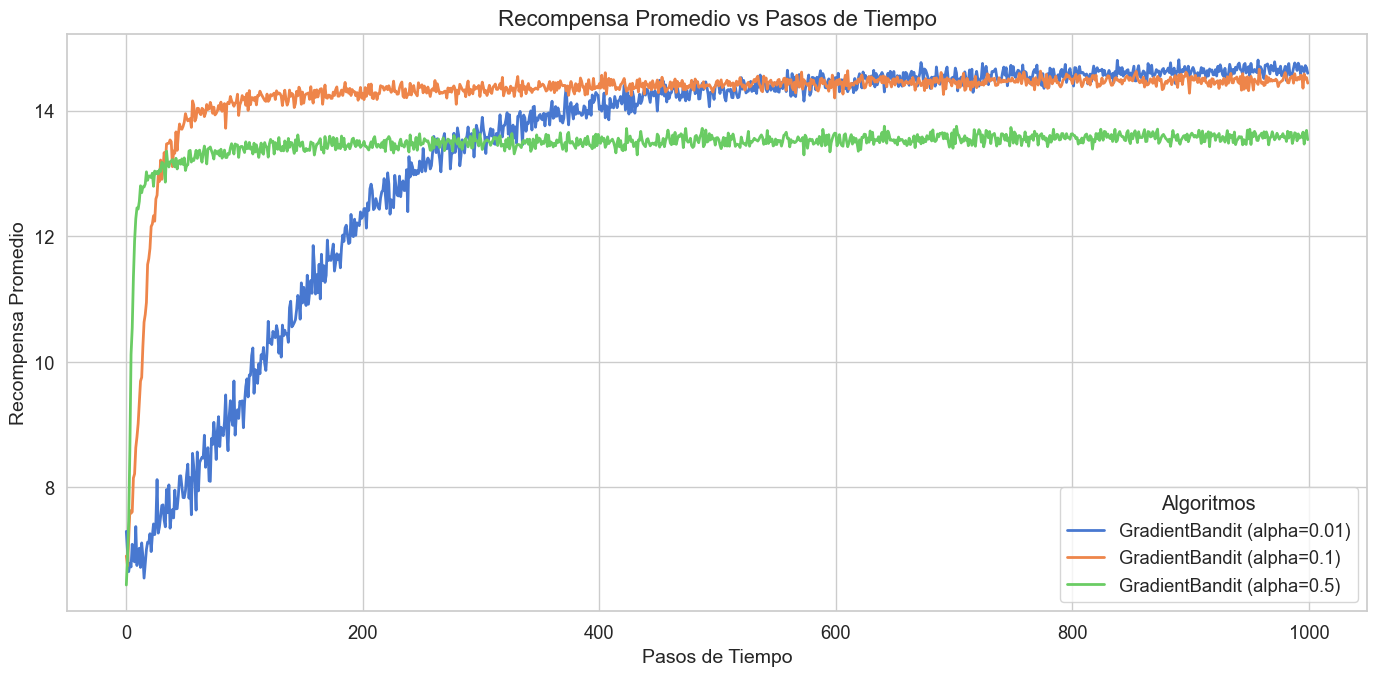

In [7]:
plot_average_rewards(steps, gradient_rewards, gradient_algorithms)

- **GradientBandit (alpha=0.01):** al inicio, la recompensa promedio es baja, pero sube de manera consistente, aunque lenta. Su valor para alpha indica una tasa de aprendizaje muy conservadora, lo que significa que las actualizaciones de las preferencias del algoritmo son muy pequeñas, lo que también evita que tenga oscilaciones bruscas, pero obteniendo un aprendizaje lento. Necesita más tiempo para adaptarse porque los ajustes en las probabilidades de selección de acciones son mínimos en cada paso.
- **GradientBandit (alpha=0.1):** consigue rápidamente mejores resultados en la recompensa, estabilizándose alrededor de 14. Muestra un buen balance entre velocidad de aprendizaje y estabilidad. Parece que su valor para alpha es el más ideal de los tres, ya que la tasa de aprendizaje tiene una suficiente sensibilidad como para identificar la mejor acción rápidamente sin ser demasiado reactivo.
- **GradientBandit (alpha=0.5):** es la que más recompensa promedio consigue al inicio, pero cuando consigue estabilizarse, tiene la peor recompensa. Un valor alto de alpha, como 0.5, hace que el algoritmo sea demasiado agresivo en sus actualizaciones. Esto significa que los cambios en las preferencias son bruscos y están muy influenciados por recompensas recientes, y esa alta sensibilidad lleva a un comportamiento inestable.

### Rechazo acumulado

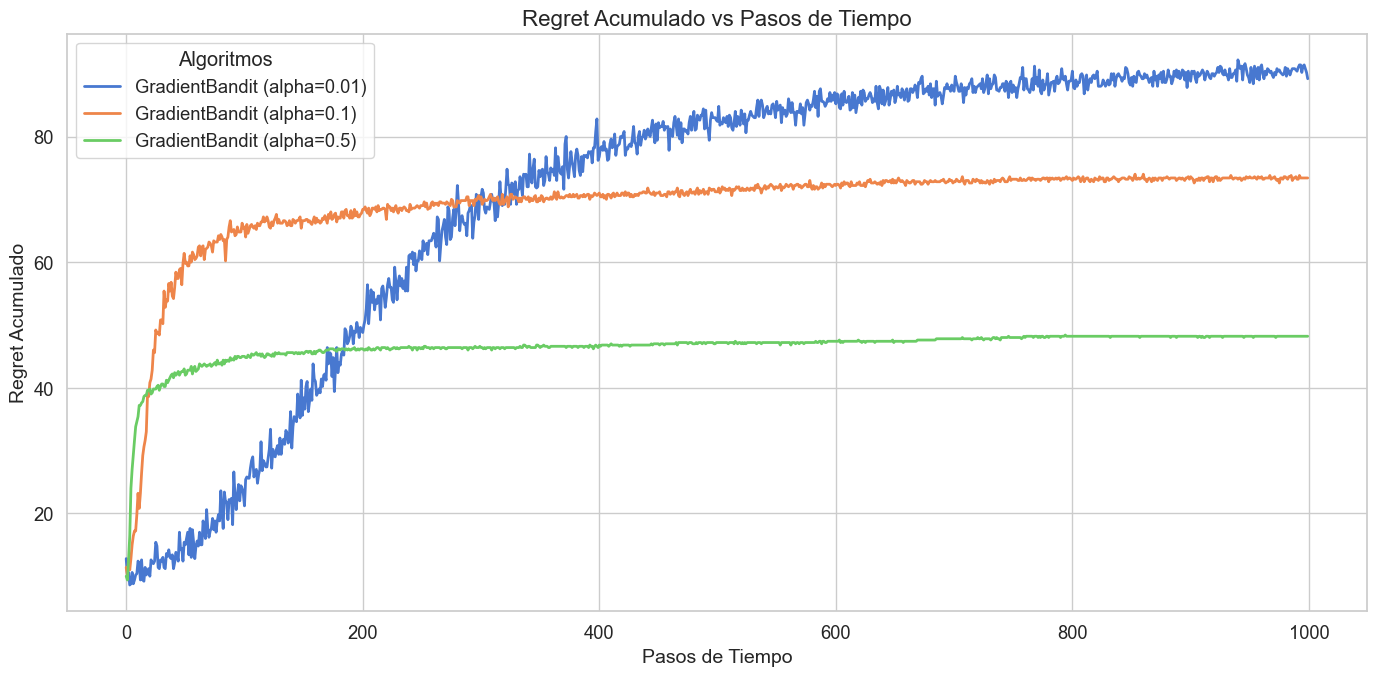

In [8]:
plot_regret(steps, gradient_optimal_selections, gradient_algorithms)

- **GradientBandit (alpha=0.01):** observamos un nivel de rechazo acumulado elevado, especialmente en los pasos finales, y una notable cantidad de fluctuaciones a lo largo del tiempo. Al tener una tasa de aprendizaje baja, en los momentos iniciales el rechazo crece de forma constante, ya que escoge tarda en cambiar de elección. Las fluctuaciones se deben a la exploración más prolongada, dado que el aprendizaje lento impide que el modelo se estabilice rápidamente en la acción óptima.
- **GradientBandit (alpha=0.1):** inicialmente crece muy rápido, debido a que la tasa de aprendizaje más elevada le lleva a explorar más, elevando el rechazo obtenido y, por lo tanto, el rechazo acumulado. A pesar de ello, consigue estabilizarse antes del paso 200, minimizando en cada etapa el rechazo.
- **GradientBandit (alpha=0.5):** es un caso parecido al anterior, pero al tener una tasa de aprendizaje más elevada, crece más rápido al inicio, aunque consigue estabilizarse antes y con un rechazo acumulado bastante menor, por debajo de 50. Con estos resultados, se corre el riesgo de que el algoritmo se ajuste demasiado a las recompensas inmediatas. 

## Softmax vs Gradiente de preferencias

En este apartado vamos a comparar ambos algoritmos.

### Recompensa promedio

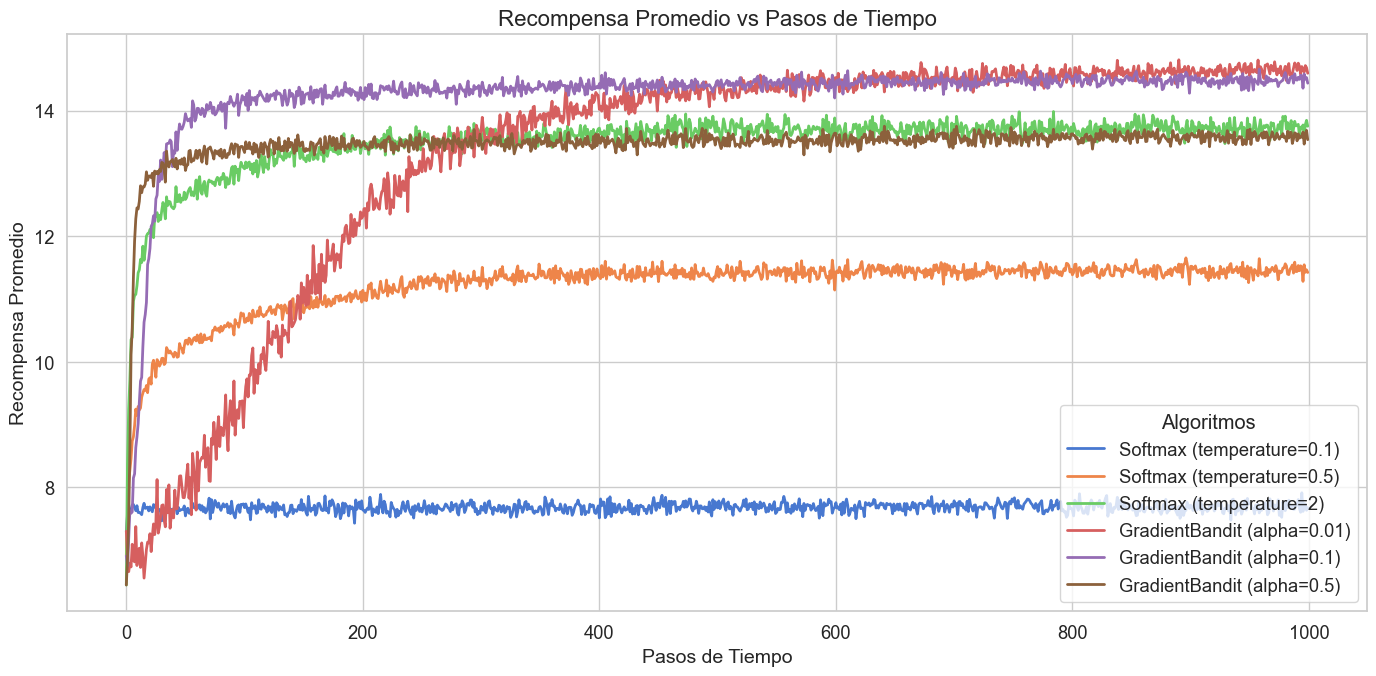

In [9]:
plot_average_rewards(steps, np.vstack((softmax_rewards, gradient_rewards)), softmax_algorithms+gradient_algorithms)

Vemos como las mejores recompensas promedio con este tipo de distribución, se consiguen con el Gradiente de Preferencias, con un valor para alpha de 0.01 (aunque tarda bastante en superar a su hermano de 0.1, el cuál llega bastante rápido a ese valor).

Por otro lado, las configuraciones de Softmax con temperaturas bajas o moderadas tienen un desempeño inferior, ya que no logran balancear adecuadamente la exploración y explotación, resultando en recompensas más bajas y altos niveles de rechazo acumulado. Esto resalta la importancia de ajustar adecuadamente los parámetros al contexto del problema para optimizar el rendimiento.

### Rechazo acumulado

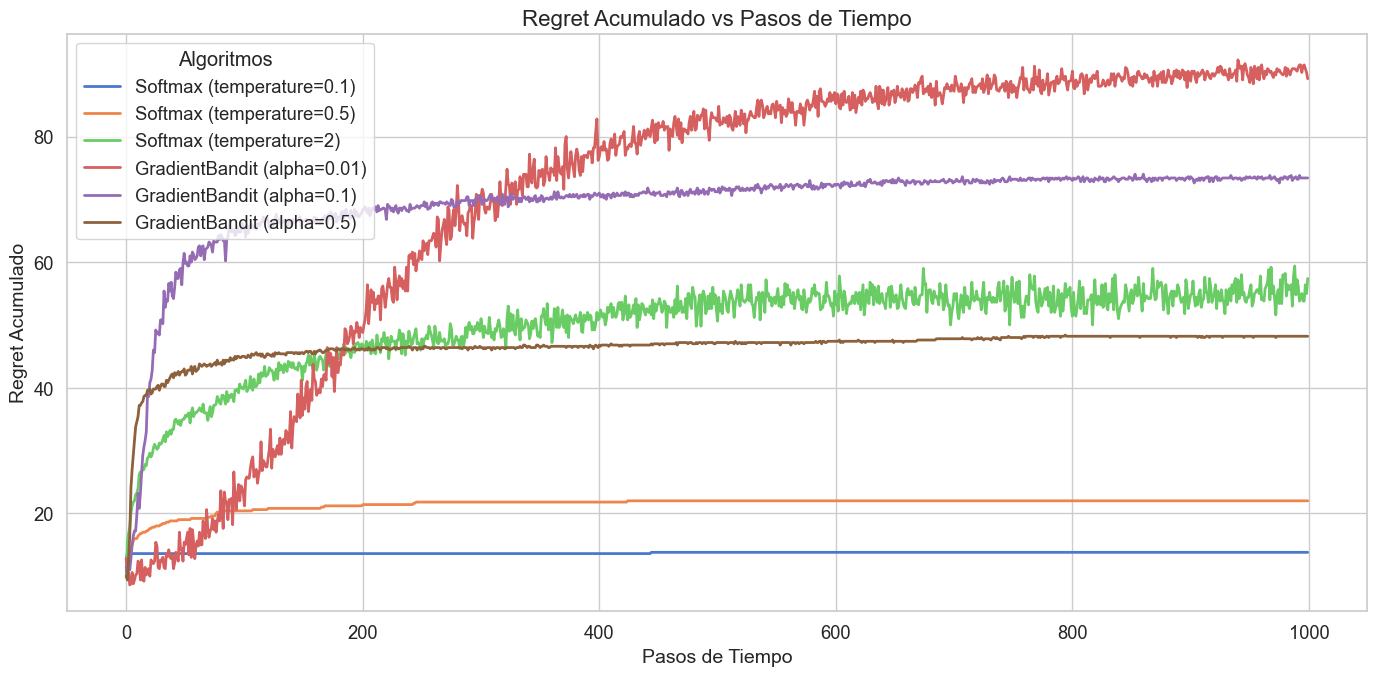

In [10]:
plot_regret(steps, np.vstack((softmax_optimal_selections, gradient_optimal_selections)), softmax_algorithms+gradient_algorithms)

Cuando analizamos el rechazo acumulado junto con la recompensa promedio, los algoritmos GradientBandit con alpha = 0.1 y alpha = 0.5 son los claros ganadores. Logran balancear la exploración y explotación, minimizando el rechazo acumulado mientras maximizan las recompensas. Por el contrario, los algoritmos Softmax, especialmente con temperaturas bajas, demuestran un desempeño deficiente debido a su falta de adaptabilidad al entorno.